In [7]:
#Packages
from osgeo import gdal, ogr, gdal_array
import numpy as np
import numpy as geek
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io as io
from pathlib import Path
from glob import glob
from PIL import Image, ImageStat

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, cohen_kappa_score
from time import process_time


#Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()


In [8]:
#Open image
ras_img = r"C:\Users\Praveen Palani\VS CODE REPOS\vs-code-local\Python-demos\ImageReading\Ahmedabad_cityRFComposite.tif"
im = gdal.Open(ras_img, gdal.GA_ReadOnly)

#Print rows, columns and bands in image
row = im.RasterYSize
col = im.RasterXSize
n_bands = im.RasterCount
geo_transform = im.GetGeoTransform ()
projection = im.GetProjectionRef ()
print (row, col)
print (n_bands)

5833 4680
16


In [9]:
#Convert image to numpy array - Read all band information and store as array
im_array = []
for i in range (1, n_bands+1):
    band = im.GetRasterBand(i)
    im_array.append(band.ReadAsArray ())
    
#Stack the array
array_new = np.stack (im_array, axis = 2)
array_new = np.reshape (im_array, [row, col, n_bands]) 
print ("Shape of stacked array: {sz}".format(sz=array_new.shape))

Shape of stacked array: (5833, 4680, 16)


In [10]:
#csv data
#Transform csv file to dataframe
df = pd.read_csv (r"C:\Users\Praveen Palani\VS CODE REPOS\vs-code-local\Python-demos\ImageReading\Ahmedabad.txt", sep = ',')
print (df.head())
# Train test split
X = df.drop (['XCoord', 'YCoord', 'OBJECTID', 'CLASS'], axis=1).values
y = df['CLASS']  

# Split dataset into train set and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
print('Size of X matrix is: {sz}'.format(sz=X.shape))
print('Size of y array is: {sz}'.format(sz=y.shape))

         XCoord        YCoord  OBJECTID  CLASS  BAND_1  BAND_2  BAND_3  \
0  8.090094e+06  2.634496e+06         1      1     150     119     141   
1  8.083600e+06  2.637024e+06         2      1     150     120     144   
2  8.090177e+06  2.634502e+06         3      1     150     124     147   
3  8.090121e+06  2.634535e+06         4      1     147     121     147   
4  8.077528e+06  2.627929e+06         5      1     148     116     138   

   BAND_4  BAND_5  BAND_6  BAND_7  BAND_8  BAND_9  BAND_10  BAND_11  BAND_12  \
0      46     100      79      94      31       5        5        5        3   
1      49     100      80      96      33       4        4        4        2   
2      44     100      83      98      29      10        7        6        3   
3      49      98      81      98      32      11        6        5        4   
4      45      99      77      92      30       5        5        4        3   

   BAND_13  BAND_14  BAND_15  BAND_16  
0      750      740      600      

In [11]:
#Random Forest classifier
rf = RandomForestClassifier (n_estimators=500, n_jobs=-1,oob_score=True)
rf = rf.fit (X_train, y_train)
#Predictions on test data
y_pred = rf.predict(X_test)
print (y_pred)

[2 1 1 1 2 2 2 3 2 2 2 2 2 1 3 2 3 1 3 3 1 3 2 2 3 1 1 3 1 1 2 2 3 2 3 2 1
 3 3 3 3 2 1 3 3 1 1 2 1 1 3 1 3 2 2 3 1 2 1 3 1 3 2 3 3 3 2 3 2 2 3 1 3 2
 3 2 1 1 2 1 2 2 1 1 1 1 1 2 3 2 1 3 3 1 2 2 2 1 3 1 2 1 2 3 2 2 1 1 1 3 1
 2 1 3 2 3 3 3 2 3 3 2 1 3 1 2 3 1 2 1 3 1 1 2 3]


In [12]:
#Accuracy report 
print ("Confusion matrix of the test data:\n", confusion_matrix (y_test, y_pred))
print("Accuracy report of the test data:\n", classification_report(y_test, y_pred))
print ("The OOB score is {oob}%".format(oob=rf.oob_score_ * 100))

Confusion matrix of the test data:
 [[41  1  0]
 [ 0 44  0]
 [ 4  1 44]]
Accuracy report of the test data:
               precision    recall  f1-score   support

           1       0.91      0.98      0.94        42
           2       0.96      1.00      0.98        44
           3       1.00      0.90      0.95        49

    accuracy                           0.96       135
   macro avg       0.96      0.96      0.96       135
weighted avg       0.96      0.96      0.96       135

The OOB score is 95.87301587301587%


In [13]:
#Band importance
band_name = range(1,n_bands+1)
for i, imp in zip(band_name, rf.feature_importances_):
    print('Band {i} Significance is {imp}'.format(i=i, imp=imp))
    
#Save band importance in an array

Band 1 Significance is 0.02237925892848301
Band 2 Significance is 0.06888457601084383
Band 3 Significance is 0.046362340199260214
Band 4 Significance is 0.1193027725731864
Band 5 Significance is 0.0249162194604318
Band 6 Significance is 0.06445305384011699
Band 7 Significance is 0.05221025570992468
Band 8 Significance is 0.08439361069793033
Band 9 Significance is 0.026064755917809684
Band 10 Significance is 0.022072690492385798
Band 11 Significance is 0.034481029855438654
Band 12 Significance is 0.0970045910404988
Band 13 Significance is 0.03396894270588115
Band 14 Significance is 0.075960057090901
Band 15 Significance is 0.0741706930243757
Band 16 Significance is 0.15337515245253197


In [14]:
#Classifying the image
#Reshape the image array from 3d to 2d
array_new_shp = (array_new.shape[0] * array_new.shape[1], array_new.shape[2])
array_new_rshp = array_new [:, :, :].reshape(array_new_shp)
print("Array is now reshaped from {o} to {n}".format(o = array_new.shape, n = array_new_rshp.shape))

#Making predictions for all pixels
im_pred = rf.predict (array_new_rshp)

#Reshape the classified map to original raster extent
im_pred = im_pred.reshape(array_new [:, :, 0].shape)
print ("Dimension of classified map is {o}". format(o = im_pred.shape))

Array is now reshaped from (5833, 4680, 16) to (27298440, 16)
Dimension of classified map is (5833, 4680)


In [15]:
ou_im = r"C:\Users\Praveen Palani\VS CODE REPOS\vs-code-local\Python-demos\ImageReading\test4.tif"
def createGeotiff (ou_im, X, geo_transform, projection):
    driver = gdal.GetDriverByName('GTiff')
    row, col = X.shape
    rasterDS = driver.Create (ou_im, col, row, 1, gdal.GDT_Byte)
    rasterDS.SetGeoTransform (geo_transform)
    rasterDS.SetProjection (projection)
    band = rasterDS.GetRasterBand (1)
    band.WriteArray (X)
    rasterDS = None
    #FlushCache ()
    
#Call the function
createGeotiff (ou_im, im_pred, geo_transform, projection)

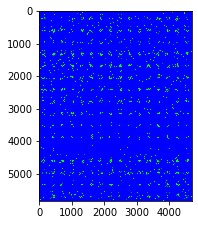

In [16]:
#Visualise the classified image
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(array_new, [4, 3, 2], (0, 8000))

n = im_pred.max()

# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 150, 0, 255)),  # Industrial
    (2, (0, 0, 255, 255)),  # Residential
    (3, (0, 255, 0, 255)),  # Small Non Residential
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

#Now show the class map next to the image
plt.subplot(122)
plt.imshow(im_pred, cmap=cmap, interpolation='none')

plt.show()

In [17]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# import io
from PIL import Image
from osgeo import gdal
import cv2
import rasterio
import numpy as np
from osgeo import gdal

In [18]:
dataset = gdal.Open(r"C:\Users\Praveen Palani\VS CODE REPOS\vs-code-local\Python-demos\ImageReading\Ahmedabad_cityRFComposite.tif", gdal.GA_ReadOnly) 

In [19]:
datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0.5,
        
        horizontal_flip=True,
        vertical_flip = True,
        fill_mode='nearest') 

In [20]:
a = 1
ds = gdal.Open(r"C:\Users\Praveen Palani\VS CODE REPOS\vs-code-local\Python-demos\ImageReading\Ahmedabad_cityRFComposite.tif")

while True:
    band = ds.GetRasterBand(a)
    myarray = band.ReadAsArray()
    x = img_to_array(myarray)
    x = x.reshape(x.shape + (1, ))  
    i = 1
    for batch in datagen.flow(x, batch_size=16,  
        save_to_dir='C:\\Users\\Praveen Palani\\VS CODE REPOS\\vs-code-local\\Python-demos\\ImageReading', 
        save_prefix= a, 
        save_format='tif'):
        i += 1
        if i > 1:
            break 
    a += 1
    if a > 16: #ensures you get all 12 bands
        break
del ds

In [21]:
print("Array is now reshaped from {o} to {n}".format(o = myarray.shape, n = myarray.shape))


Array is now reshaped from (5833, 4680) to (5833, 4680)
